Total Return: 14.96%
Annualized Return: 5.00%
Sharpe Ratio: 2.67
Max Drawdown: -0.81%
Latest Signal: BUY
Signal generated at: 1970-01-01 00:00:01.722537780
Current price: 161.86
Signal price: 158.13


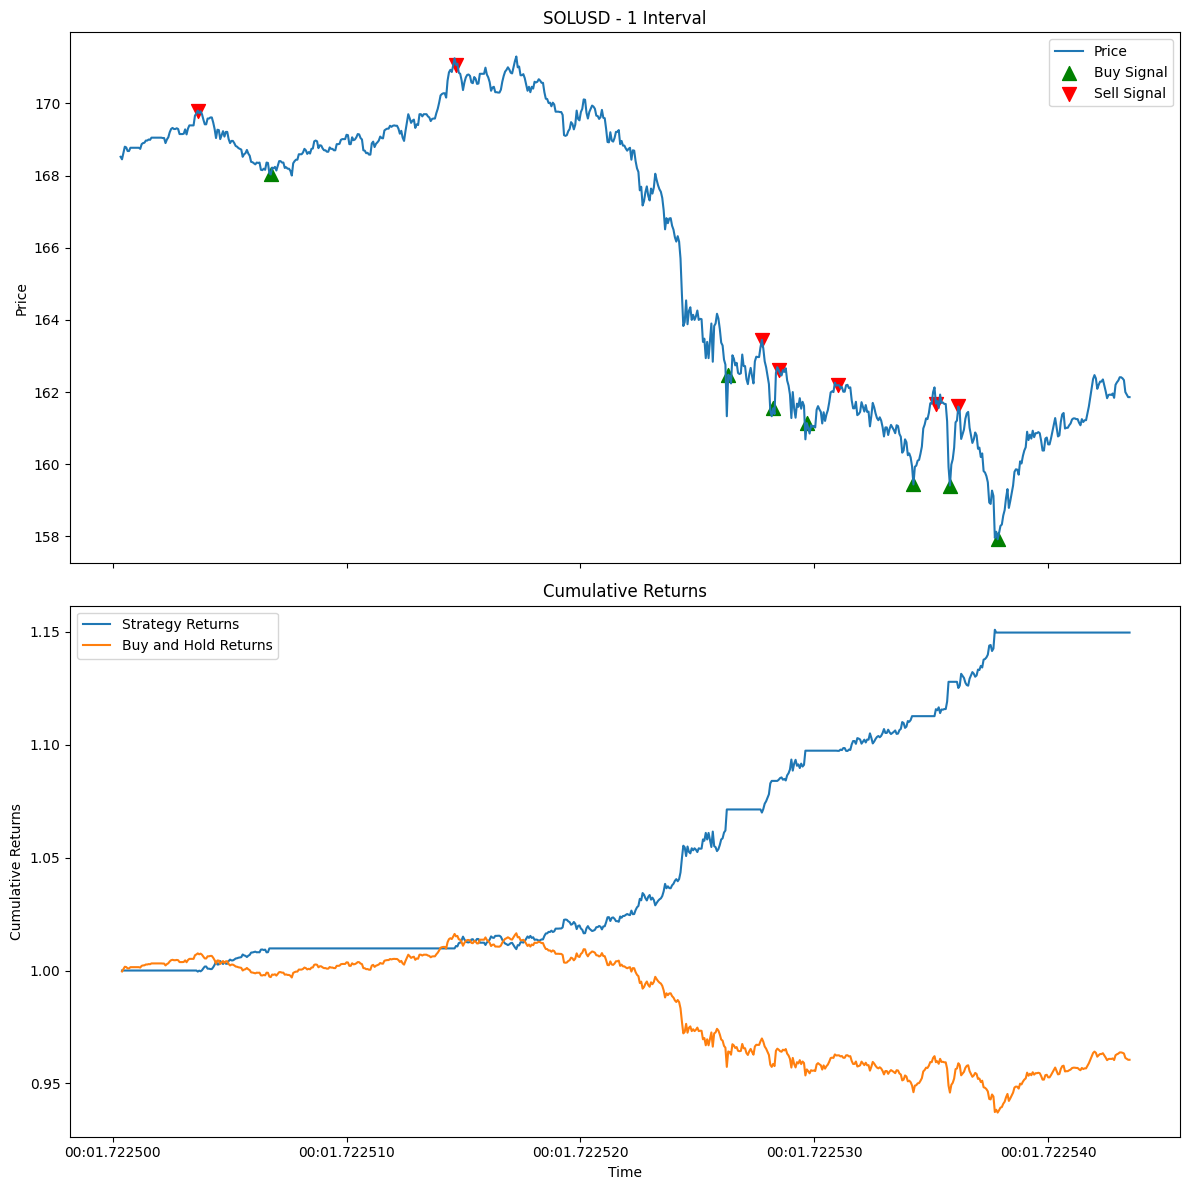

In [167]:
import pandas as pd
import numpy as np
import pywt
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import requests

class Signal:
    def __init__(self, asset, interval, level, prominence=1, distance=10, price_col='close', time_col='time', volume_col='volume'):
        self.asset = asset
        self.interval = interval
        self.level = level
        self.prominence = prominence
        self.distance = distance
        self.price_col = price_col
        self.time_col = time_col
        self.volume_col = volume_col
        self.df = None

    def load_data(self):
        # get data for the last 720 candles from kraken api
        url = "https://api.kraken.com/0/public/OHLC"
        querystring = {"pair": self.asset,"interval": self.interval}
        headers = {
        'Accept': 'application/json'
        }
        response = requests.request("GET", url, params=querystring)

        # parse the json response and create a dataframe
        data = response.json()
        df = pd.DataFrame(data['result'][self.asset], columns=['time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count'])

        #besides time and count are strings so we need to convert them to floats
        df['close'] = df['close'].astype(float)
        df['open'] = df['open'].astype(float)
        df['high'] = df['high'].astype(float)
        df['low'] = df['low'].astype(float)
        df['vwap'] = df['vwap'].astype(float)
        df['volume'] = df['volume'].astype(float)
        df['count'] = df['count'].astype(float)
        # create returns column
        df['returns'] = df['close'].pct_change()
        

    
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
        self.df = df

    def identify_peaks_valleys(self):
        if self.price_col not in self.df.columns:
            raise KeyError(f"Column '{self.price_col}' not found in the DataFrame. Available columns are: {', '.join(self.df.columns)}")

        # Apply wavelet transform
        coeffs = pywt.wavedec(self.df[self.price_col], 'db1', level=self.level)
        reconstructed = pywt.waverec(coeffs[:-1] + [None] * 1, 'db1')

        # Find peaks and valleys
        peaks, _ = find_peaks(reconstructed, prominence=self.prominence, distance=self.distance)
        valleys, _ = find_peaks(-reconstructed, prominence=self.prominence, distance=self.distance)

        # Create columns for peaks, valleys, and signals
        self.df['peak'] = 0
        self.df['valley'] = 0
        self.df['signal'] = 0

        self.df.iloc[peaks, self.df.columns.get_loc('peak')] = 1
        self.df.iloc[valleys, self.df.columns.get_loc('valley')] = 1

        # Generate buy/sell signals
        self.df.loc[self.df['valley'] == 1, 'signal'] = 1  # Buy signal
        self.df.loc[self.df['peak'] == 1, 'signal'] = -1   # Sell signal

        # Shift signals by 1 to represent execution on next available price
        self.df['buy_signal'] = (self.df['signal'] == 1).astype(int).shift(1)
        self.df['sell_signal'] = (self.df['signal'] == -1).astype(int).shift(1)

    def generate_positions(self):
        self.df['position'] = self.df['signal'].cumsum().shift(1).fillna(0)
        self.df['strategy_returns'] = self.df['position'] * self.df['returns']
        self.df['cumulative_returns'] = (1 + self.df['strategy_returns']).cumprod()

    def plot_signals_and_returns(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

        # Plot price and signals
        ax1.plot(self.df.index, self.df[self.price_col], label='Price')
        ax1.scatter(self.df.index[self.df['buy_signal'] == 1], 
                    self.df.loc[self.df['buy_signal'] == 1, self.price_col], 
                    color='green', marker='^', s=100, label='Buy Signal')
        ax1.scatter(self.df.index[self.df['sell_signal'] == 1], 
                    self.df.loc[self.df['sell_signal'] == 1, self.price_col], 
                    color='red', marker='v', s=100, label='Sell Signal')
        ax1.set_title(f'{self.asset} - {self.interval} Interval')
        ax1.set_ylabel('Price')
        ax1.legend()

        # Plot cumulative returns
        ax2.plot(self.df.index, self.df['cumulative_returns'], label='Strategy Returns')
        ax2.plot(self.df.index, (1 + self.df['returns']).cumprod(), label='Buy and Hold Returns')
        ax2.set_title('Cumulative Returns')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Cumulative Returns')
        ax2.legend()

        plt.tight_layout()
        plt.show()

    def calculate_performance_metrics(self):
        total_return = self.df['cumulative_returns'].iloc[-1] - 1
        annualized_return = (1 + total_return) ** (252 / len(self.df)) - 1
        sharpe_ratio = np.sqrt(252) * self.df['strategy_returns'].mean() / self.df['strategy_returns'].std()
        max_drawdown = (self.df['cumulative_returns'] / self.df['cumulative_returns'].cummax() - 1).min()
        
        print(f"Total Return: {total_return:.2%}")
        print(f"Annualized Return: {annualized_return:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2%}")

    def get_latest_signal(self):
        """
        Returns the latest signal based on the most recent data.
        If the latest signal is HOLD, it returns the last non-zero signal.
        
        Returns:
        - 1 if the latest signal is a buy
        - -1 if the latest signal is a sell
        - 0 if there's no signal and no previous non-zero signal
        """
        latest_buy = self.df['buy_signal'].iloc[-1]
        latest_sell = self.df['sell_signal'].iloc[-1]
        
        if latest_buy == 1:
            return 1
        elif latest_sell == 1:
            return -1
        else:
            # If current signal is HOLD, find the last non-zero signal
            non_zero_signals = self.df[self.df['signal'] != 0]['signal']
            if not non_zero_signals.empty:
                return non_zero_signals.iloc[-1]
            else:
                return 0

    def run_analysis(self):
        self.identify_peaks_valleys()
        self.generate_positions()
        self.calculate_performance_metrics()
        latest_signal = self.get_latest_signal()
        signal_map = {1: "BUY", -1: "SELL", 0: "HOLD"}
        print(f"Latest Signal: {signal_map[latest_signal]}")
    
        # Additional information about the signal
        if latest_signal != 0:
            signal_time = self.df.index[self.df['signal'] == latest_signal][-1]
            print(f"Signal generated at: {signal_time}")
            print(f"Current price: {self.df[self.price_col].iloc[-1]:.2f}")
            print(f"Signal price: {self.df.loc[signal_time, self.price_col]:.2f}")
        else:
            print("No signals generated yet.")

    def plot(self):
        self.plot_signals_and_returns()


signal = Signal(asset='SOLUSD', interval='1', level=1, prominence=1.1, distance=10)
signal.load_data()
signal.run_analysis()
signal.plot()


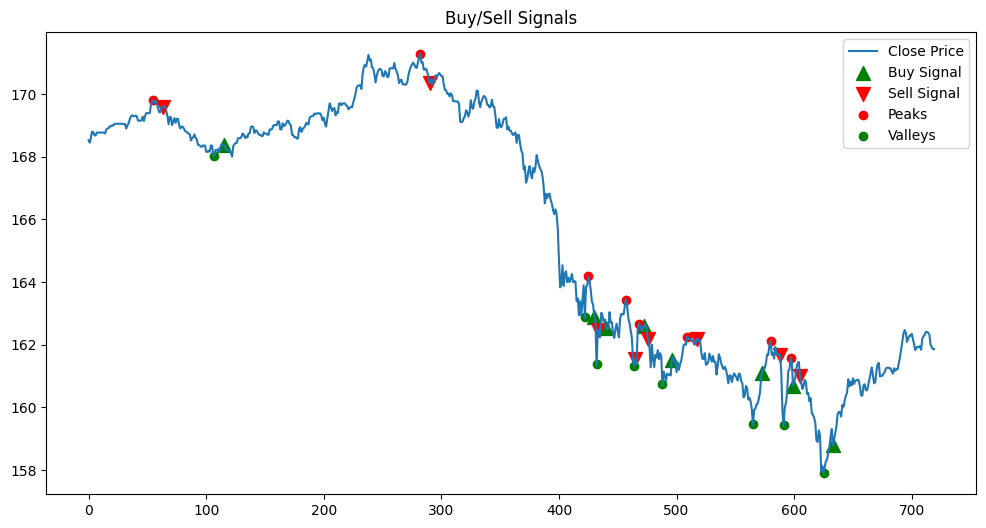

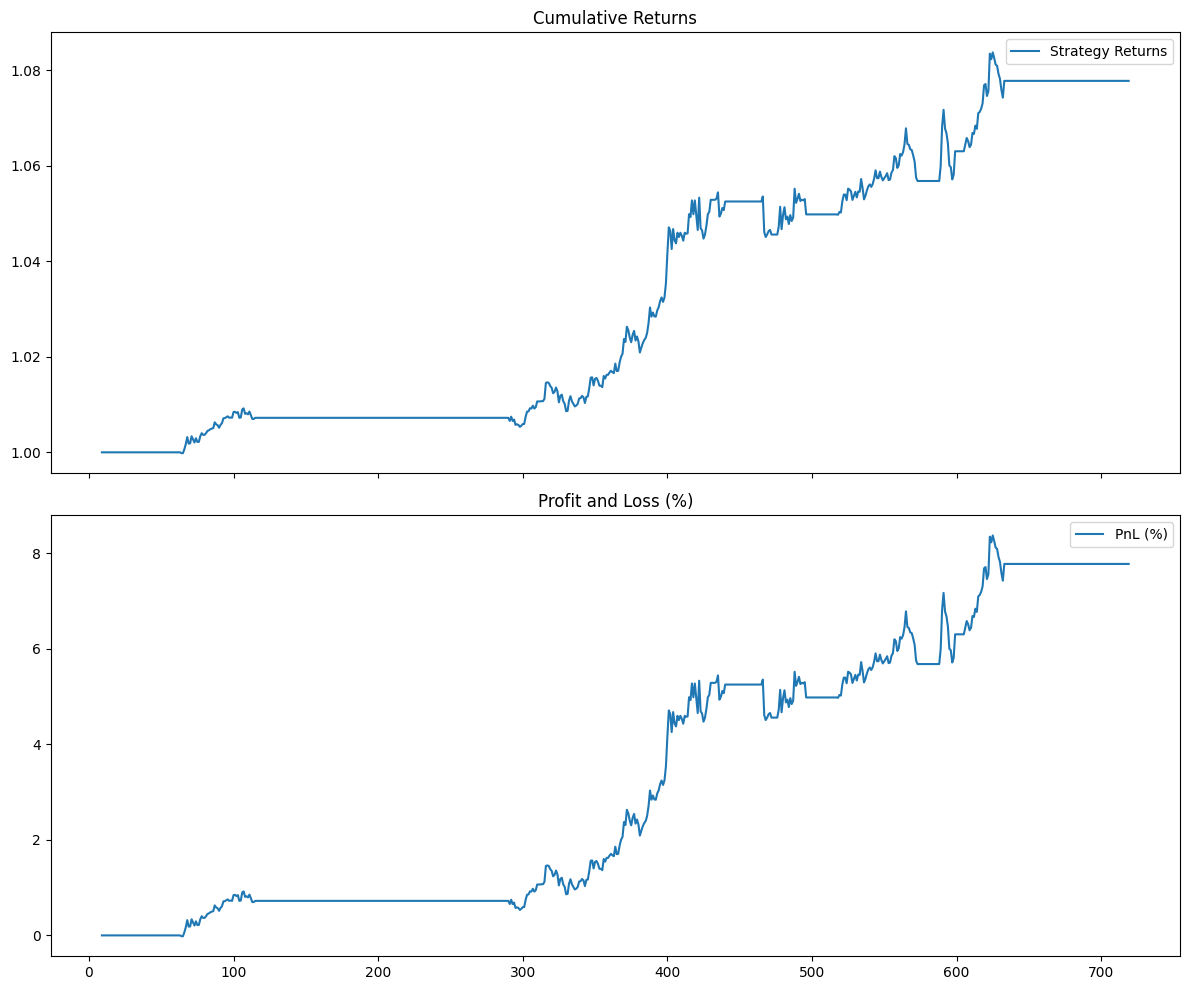

{'last_signal': 0.0, 'last_non_zero_position': 1, 'periods_since_last_signal': 86, 'last_non_zero_close_price': 158.79, 'current_close_price': 161.86}


In [168]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import requests

class Wave_Strat:
    def __init__(self, df, signal_delay, prominence, distance, level):
        self.df = df.copy()
        self.signal_delay = signal_delay
        self.prominence = prominence
        self.distance = distance
        self.level = level
        self.denoised_close = None
        self.peaks = None
        self.valleys = None
        self.signals = None
        self.positions = None
        self.returns = None
        
        self.denoise_close()
        self.find_peaks_valleys()
        self.generate_signals()
        self.calculate_returns()

    def denoise_close(self):
        # Wavelet denoising
        close = self.df['close'].values
        coeffs = pywt.wavedec(close, 'db8', level=self.level)
        coeffs[1:] = [pywt.threshold(i, value=0.05*max(i), mode='soft') for i in coeffs[1:]]
        self.denoised_close = pywt.waverec(coeffs, 'db8')
        self.df['denoised_close'] = self.denoised_close

    def find_peaks_valleys(self):
        # Find peaks and valleys
        self.peaks, _ = find_peaks(self.denoised_close, prominence=self.prominence, distance=self.distance)
        self.valleys, _ = find_peaks(-self.denoised_close, prominence=self.prominence, distance=self.distance)

    def generate_signals(self):
        # Generate buy/sell signals
        self.signals = pd.Series(index=self.df.index, data=0)
        self.signals.iloc[self.peaks] = -1  # Sell signal
        self.signals.iloc[self.valleys] = 1  # Buy signal
        
        # Adjust signals for delay
        self.signals = self.signals.shift(self.signal_delay)
        self.df['signal'] = self.signals

    def calculate_returns(self):
        # Calculate strategy returns
        self.positions = self.signals.cumsum()
        self.df['position'] = self.positions
        self.df['returns'] = self.df['close'].pct_change()
        self.df['strategy_returns'] = self.df['position'].shift(1) * self.df['returns']
        self.df['cumulative_returns'] = (1 + self.df['strategy_returns']).cumprod()

    def plot_signals(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.df.index, self.df['close'], label='Close Price')
        plt.scatter(self.df.index[self.df['signal'] == 1], self.df.loc[self.df['signal'] == 1, 'close'], 
                    marker='^', color='g', label='Buy Signal', s=100)
        plt.scatter(self.df.index[self.df['signal'] == -1], self.df.loc[self.df['signal'] == -1, 'close'], 
                    marker='v', color='r', label='Sell Signal', s=100)
        plt.scatter(self.df.index[self.peaks], self.denoised_close[self.peaks], color='r', label='Peaks')
        plt.scatter(self.df.index[self.valleys], self.denoised_close[self.valleys], color='g', label='Valleys')
        plt.title('Buy/Sell Signals')
        plt.legend()
        plt.show()

    def plot_peaks_valleys(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.df.index, self.denoised_close, label='Denoised Close')
        plt.scatter(self.df.index[self.peaks], self.denoised_close[self.peaks], color='r', label='Peaks')
        plt.scatter(self.df.index[self.valleys], self.denoised_close[self.valleys], color='g', label='Valleys')
        plt.title('Peaks and Valleys')
        plt.legend()
        plt.show()

    def plot_denoised_trend(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.df.index, self.df['close'], label='Original Close')
        plt.plot(self.df.index, self.denoised_close, label='Denoised Close')
        plt.title('Original vs Denoised Close Price')
        plt.legend()
        plt.show()

    def get_last_signal(self):
        last_signal = self.df['signal'].iloc[-1]
        
        # Find the last non-zero signal
        non_zero_signals = self.df['signal'][self.df['signal'] != 0]
        signal_type = None
        periods_since_last_signal = None
        if not non_zero_signals.empty:
            last_non_zero_signal = non_zero_signals.iloc[-1]
            last_non_zero_index = non_zero_signals.index[-1]
            periods_since_last_signal = len(self.df) - 1 - self.df.index.get_loc(last_non_zero_index)
            
            if last_non_zero_signal == 1:
                signal_type = 1
            else:
                signal_type = -1
        
        return {
            "last_signal": last_signal,
            "last_non_zero_position": signal_type,
            "periods_since_last_signal": periods_since_last_signal,
            "last_non_zero_close_price": self.df['close'].iloc[last_non_zero_index],
            "current_close_price": self.df['close'].iloc[-1]    
        }

    def plot_backtest_results(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        
        # Plot cumulative returns
        ax1.plot(self.df.index, self.df['cumulative_returns'], label='Strategy Returns')
        ax1.set_title('Cumulative Returns')
        ax1.legend()
        
        # Plot PnL
        pnl = (self.df['cumulative_returns'] - 1) * 100
        ax2.plot(self.df.index, pnl, label='PnL (%)')
        ax2.set_title('Profit and Loss (%)')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()


    # get data for the last 720 candles from kraken api
url = "https://api.kraken.com/0/public/OHLC"
querystring = {"pair": "SOLUSD","interval": '1'}
headers = {
'Accept': 'application/json'
}
response = requests.request("GET", url, params=querystring)

# parse the json response and create a dataframe
data = response.json()
df = pd.DataFrame(data['result']["SOLUSD"], columns=['time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count'])

#besides time and count are strings so we need to convert them to floats
df['close'] = df['close'].astype(float)
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['vwap'] = df['vwap'].astype(float)
df['volume'] = df['volume'].astype(float)
df['count'] = df['count'].astype(float)
# create returns column
df['returns'] = df['close'].pct_change()

# ---- Execution ---- #
strategy = Wave_Strat(df, signal_delay=8, prominence=1.1, distance=10, level=1)
# Plot results
strategy.plot_signals()
# strategy.plot_peaks_valleys()
# strategy.plot_denoised_trend()
strategy.plot_backtest_results()


# Get last signal
print(strategy.get_last_signal())


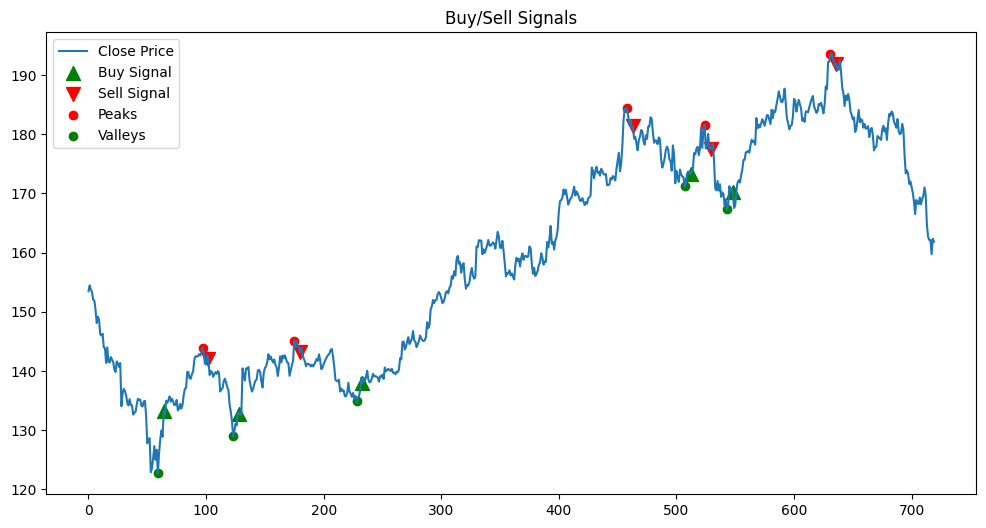

{'last_signal': 0.0, 'last_non_zero_position': -1, 'periods_since_last_signal': 83, 'last_non_zero_close_price': 191.78, 'current_close_price': 161.86}


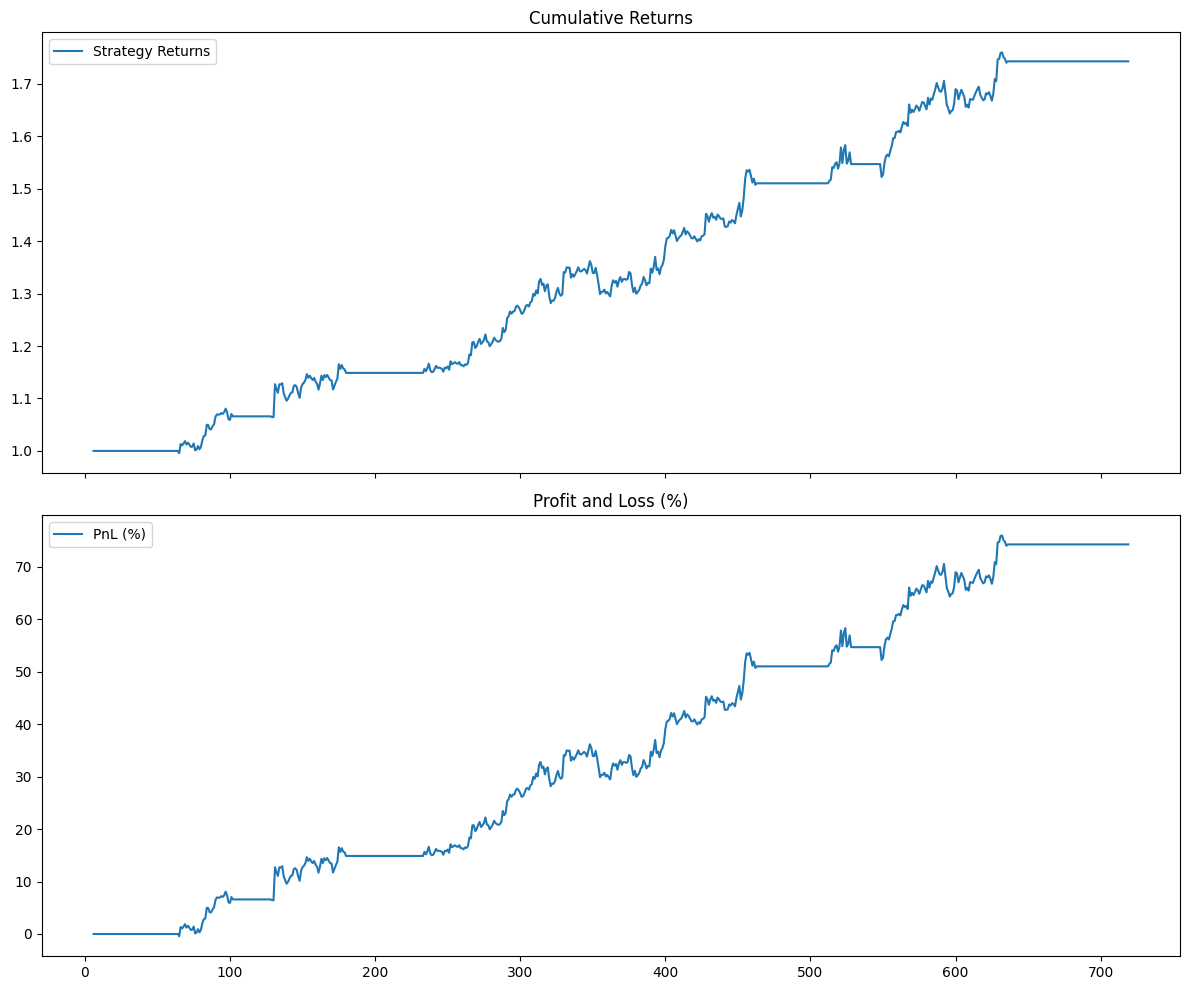

In [169]:

    # get data for the last 720 candles from kraken api
url = "https://api.kraken.com/0/public/OHLC"
querystring = {"pair": "SOLUSD","interval": '60'}
headers = {
'Accept': 'application/json'
}
response = requests.request("GET", url, params=querystring)

# parse the json response and create a dataframe
data = response.json()
df = pd.DataFrame(data['result']["SOLUSD"], columns=['time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count'])

#besides time and count are strings so we need to convert them to floats
df['close'] = df['close'].astype(float)
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['vwap'] = df['vwap'].astype(float)
df['volume'] = df['volume'].astype(float)
df['count'] = df['count'].astype(float)
# create returns column
df['returns'] = df['close'].pct_change()

# ---- Execution ---- #
strategy = Wave_Strat(df, 5, prominence=8, distance=10, level=1)

# Plot results
strategy.plot_signals()

# Get last signal
print(strategy.get_last_signal())
strategy.plot_backtest_results()